In [1]:
# based on https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277/data

In [2]:
# Intro
'''
Hello! This rather quick and dirty kernel shows how to get started on segmenting nuclei using a neural network in Keras. 

The architecture used is the so-called [U-Net](https://arxiv.org/abs/1505.04597), which is very common for image segmentation problems such as this. I believe they also have a tendency to work quite well even on small datasets.

Let's get started importing everything we need!
'''

"\nHello! This rather quick and dirty kernel shows how to get started on segmenting nuclei using a neural network in Keras. \n\nThe architecture used is the so-called [U-Net](https://arxiv.org/abs/1505.04597), which is very common for image segmentation problems such as this. I believe they also have a tendency to work quite well even on small datasets.\n\nLet's get started importing everything we need!\n"

In [49]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = '../PennFudanPed/TRAIN/'
TEST_PATH = '../PennFudanPed/TEST/'
MASK_PATH  = 'PedMasks'

IMAGE_PATH = 'PNGImages'
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [89]:
train_img_ids = next(os.walk(TRAIN_PATH+IMAGE_PATH))[2]

train_mask_ids = next(os.walk(TRAIN_PATH+MASK_PATH))[2]
test_ids = next(os.walk(TEST_PATH+IMAGE_PATH))[2]
print(test_ids)

['PennPed00090.png', 'PennPed00096.png', 'PennPed00085.png', 'PennPed00094.png', 'PennPed00088.png', 'PennPed00082.png', 'PennPed00092.png', 'PennPed00086.png', 'PennPed00083.png', 'PennPed00089.png', 'PennPed00081.png', 'PennPed00091.png', 'PennPed00087.png', 'PennPed00084.png', 'PennPed00093.png', 'PennPed00095.png']


In [82]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_img_ids), total=len(train_img_ids)):
    path = TRAIN_PATH + IMAGE_PATH + "/"
    img = imread(path+id_)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    
 
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    
    print(id_)
    
    path = TRAIN_PATH + MASK_PATH + "/"
    mask_ = imread(path+id_[:-4]+'_mask.png')
    
    mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
    mask = np.maximum(mask, mask_)
    mask = np.where(mask<0.001, 0, 1)
    Y_train[n] = mask
    

Getting and resizing train images and masks ... 


  6%|▋         | 10/154 [00:00<00:01, 92.20it/s]

FudanPed00001.png
FudanPed00061.png
PennPed00041.png
FudanPed00013.png
FudanPed00023.png
FudanPed00010.png
PennPed00059.png
PennPed00076.png
FudanPed00040.png
FudanPed00067.png
PennPed00045.png
PennPed00063.png
PennPed00005.png
PennPed00040.png
FudanPed00065.png
PennPed00035.png
FudanPed00011.png
PennPed00056.png


 13%|█▎        | 20/154 [00:00<00:01, 92.93it/s]

PennPed00065.png
PennPed00032.png


 18%|█▊        | 28/154 [00:00<00:01, 87.48it/s]

FudanPed00026.png
PennPed00051.png
PennPed00074.png
PennPed00049.png
PennPed00034.png
PennPed00010.png
PennPed00012.png
PennPed00016.png
FudanPed00053.png
PennPed00047.png
PennPed00070.png
PennPed00003.png
PennPed00023.png
FudanPed00052.png
FudanPed00018.png


 24%|██▍       | 37/154 [00:00<00:01, 87.26it/s]

FudanPed00029.png
FudanPed00051.png


 30%|██▉       | 46/154 [00:00<00:01, 87.43it/s]

PennPed00061.png
PennPed00020.png
PennPed00073.png
PennPed00011.png
FudanPed00012.png
PennPed00001.png
FudanPed00045.png
PennPed00080.png
FudanPed00035.png
PennPed00072.png
PennPed00036.png
FudanPed00017.png
FudanPed00002.png
FudanPed00060.png
PennPed00038.png
PennPed00024.png
FudanPed00044.png
FudanPed00063.png


 42%|████▏     | 64/154 [00:00<00:01, 84.93it/s]

FudanPed00032.png
PennPed00022.png
PennPed00008.png
PennPed00021.png
PennPed00042.png
FudanPed00006.png
PennPed00055.png
PennPed00077.png
FudanPed00054.png
PennPed00043.png
FudanPed00056.png
PennPed00033.png
FudanPed00005.png
FudanPed00058.png
PennPed00050.png
FudanPed00037.png
FudanPed00015.png
PennPed00058.png


 55%|█████▍    | 84/154 [00:00<00:00, 89.14it/s]

FudanPed00062.png
FudanPed00014.png
FudanPed00003.png
PennPed00018.png
PennPed00053.png
FudanPed00068.png
PennPed00046.png
FudanPed00071.png
PennPed00002.png
FudanPed00073.png
PennPed00004.png
FudanPed00025.png
FudanPed00066.png
PennPed00027.png
PennPed00060.png
PennPed00014.png
PennPed00019.png
FudanPed00008.png
PennPed00037.png
FudanPed00059.png


 68%|██████▊   | 105/154 [00:01<00:00, 94.72it/s]

FudanPed00016.png
PennPed00028.png
PennPed00039.png
FudanPed00039.png
PennPed00006.png
FudanPed00050.png
PennPed00079.png
PennPed00066.png
PennPed00078.png
PennPed00048.png
FudanPed00069.png
FudanPed00047.png
FudanPed00030.png
PennPed00017.png
FudanPed00046.png
FudanPed00036.png
PennPed00071.png
PennPed00025.png
FudanPed00057.png


 81%|████████  | 125/154 [00:01<00:00, 92.84it/s]

PennPed00026.png
FudanPed00064.png
FudanPed00038.png
FudanPed00072.png
PennPed00013.png
FudanPed00021.png
FudanPed00043.png
PennPed00057.png
PennPed00007.png
FudanPed00019.png
PennPed00052.png
PennPed00044.png
PennPed00068.png
PennPed00054.png
FudanPed00041.png
PennPed00031.png
PennPed00015.png
PennPed00075.png
FudanPed00074.png
FudanPed00033.png


 95%|█████████▌| 147/154 [00:01<00:00, 98.85it/s]

PennPed00067.png
FudanPed00009.png
PennPed00029.png
FudanPed00027.png
PennPed00064.png
FudanPed00004.png
FudanPed00020.png
PennPed00069.png
PennPed00062.png
FudanPed00042.png
FudanPed00034.png
FudanPed00007.png
PennPed00030.png
FudanPed00049.png
FudanPed00055.png
FudanPed00048.png
PennPed00009.png
FudanPed00024.png
FudanPed00022.png
FudanPed00031.png


100%|██████████| 154/154 [00:01<00:00, 92.26it/s]

FudanPed00028.png
FudanPed00070.png


In [92]:
# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + IMAGE_PATH + '/' + id_
    img = imread(path)[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing test images ... 


100%|██████████| 16/16 [00:00<00:00, 126.04it/s]

Done!


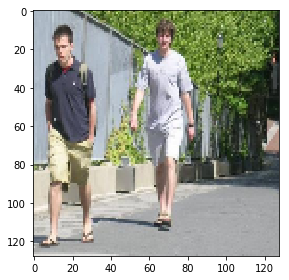

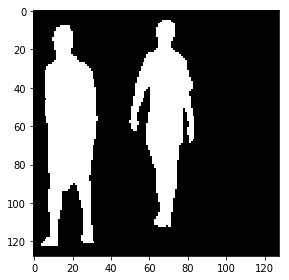

In [83]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

In [84]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [85]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 128, 128, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (

In [86]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

In [87]:


# Fit model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50, 
                    callbacks=[earlystopper, checkpointer])



Train on 138 samples, validate on 16 samples
Epoch 1/50
138/138 [==============================] - 4s 26ms/step - loss: 0.4906 - mean_iou: 0.3631 - val_loss: 0.4132 - val_mean_iou: 0.4170

Epoch 00001: val_loss improved from inf to 0.41319, saving model to model-dsbowl2018-1.h5
Epoch 2/50
138/138 [==============================] - 0s 2ms/step - loss: 0.3983 - mean_iou: 0.4230 - val_loss: 0.3882 - val_mean_iou: 0.4276

Epoch 00002: val_loss improved from 0.41319 to 0.38825, saving model to model-dsbowl2018-1.h5
Epoch 3/50
138/138 [==============================] - 0s 2ms/step - loss: 0.3496 - mean_iou: 0.4375 - val_loss: 0.4614 - val_mean_iou: 0.4478

Epoch 00003: val_loss did not improve from 0.38825
Epoch 4/50
138/138 [==============================] - 0s 2ms/step - loss: 0.3335 - mean_iou: 0.4562 - val_loss: 0.3820 - val_mean_iou: 0.4637

Epoch 00004: val_loss improved from 0.38825 to 0.38196, saving model to model-dsbowl2018-1.h5
Epoch 5/50
138/138 [==============================] -

In [93]:


# Predict on train, val and test
model = load_model('model-dsbowl2018-1.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))



16/16 [==============================] - 0s 506us/step


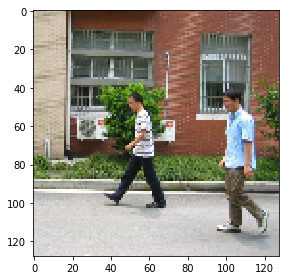

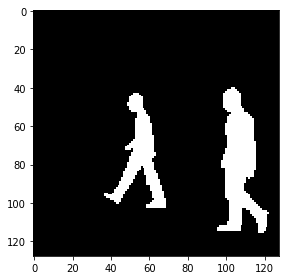

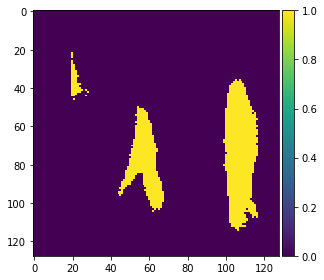

In [117]:


# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()



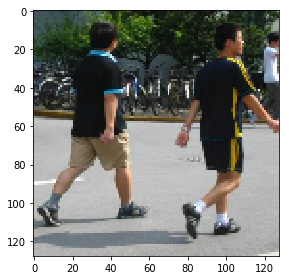

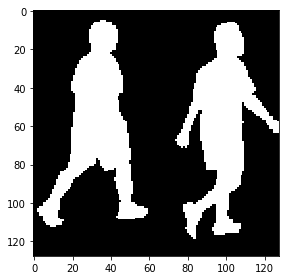

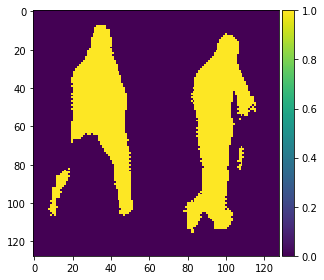

In [99]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

16
154
16
14
9


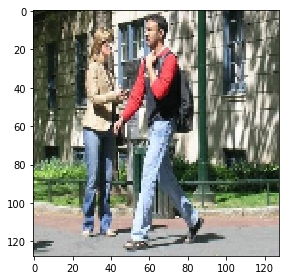

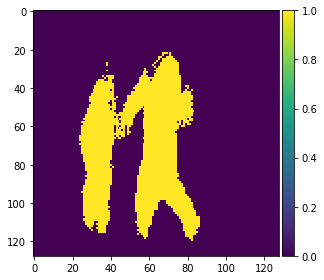

In [116]:
# Perform a sanity check on some random validation samples
print(len(preds_test_t))
ix = random.randint(0, len(preds_test_t))
print(X_train.shape[0])
print(X_test.shape[0])
print(int(X_test.shape[0]*0.9))
print(ix)
imshow(X_test[ix])
plt.show()
imshow(np.squeeze(preds_test_t[ix]))
plt.show()